In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Default path - CHANGE THIS to match your upload location
DRIVE_ROOT = '/content/drive/MyDrive/PORJECT '
print(f" Drive root set to: {DRIVE_ROOT}")

 Drive root set to: /content/drive/MyDrive/PORJECT 


##  Import Libraries & Setup

In [4]:
!pip install keras-tcn --quiet

In [27]:
# Core imports
import os
import json
import warnings
from datetime import datetime
import numpy as np
import pandas as pd

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# TCN import with fallback
try:
    from tcn import TCN
    print("  TCN library imported successfully")
    TCN_AVAILABLE = True
except ImportError as e:
    print(f"  TCN library not available: {e}")
    print("    Will use alternative dilated convolution implementation")
    TCN_AVAILABLE = False
    TCN = None

# ML utilities
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
plt.style.use('default')

# Set random seeds for reproducibility
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f" TensorFlow version: {tf.__version__}")
print(f" GPU available: {tf.config.list_physical_devices('GPU')}")

# Check GPU memory if available
if tf.config.list_physical_devices('GPU'):
    gpu = tf.config.list_physical_devices('GPU')[0]
    tf.config.experimental.set_memory_growth(gpu, True)
    print(" GPU memory growth enabled")

  TCN library imported successfully
 TensorFlow version: 2.19.0
 GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
 GPU memory growth enabled


In [28]:
# Fix TensorFlow/TCN compatibility issues
print("\n Configuring TensorFlow for TCN compatibility...")

# Enable eager execution explicitly
tf.config.run_functions_eagerly(True)

# Set memory growth for GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("    GPU memory growth configured")
    except RuntimeError as e:
        print(f"    GPU configuration warning: {e}")

print("    TensorFlow eager execution enabled for TCN compatibility")


 Configuring TensorFlow for TCN compatibility...
    GPU memory growth configured
    TensorFlow eager execution enabled for TCN compatibility


##  Define Paths & Load Data

Cấu hình paths để load artifacts đã lưu từ notebook 03.

In [6]:
# Define paths based on Drive root
DATA_SPLITS_PATH = os.path.join(DRIVE_ROOT, 'data', 'splits') + '/'
DATA_FEATURES_PATH = os.path.join(DRIVE_ROOT, 'data', 'features') + '/'
MODELS_ARCHIVED_PATH = os.path.join(DRIVE_ROOT, 'models', 'archived') + '/'
DOCS_PATH = os.path.join(DRIVE_ROOT, 'docs') + '/'

# Create output directories
os.makedirs(MODELS_ARCHIVED_PATH, exist_ok=True)
os.makedirs(DOCS_PATH, exist_ok=True)

print(" Path Configuration:")
print(f"    Data splits: {DATA_SPLITS_PATH}")
print(f"    Features: {DATA_FEATURES_PATH}")
print(f"    Models: {MODELS_ARCHIVED_PATH}")
print(f"    Docs: {DOCS_PATH}")

# Verify paths exist
required_paths = [DATA_SPLITS_PATH, DATA_FEATURES_PATH]
for path in required_paths:
    if not os.path.exists(path):
        print(f" WARNING: Path does not exist: {path}")
        print("   Make sure you've uploaded the data to Google Drive!")
    else:
        print(f" Path verified: {path}")

 Path Configuration:
    Data splits: /content/drive/MyDrive/PORJECT /data/splits/
    Features: /content/drive/MyDrive/PORJECT /data/features/
    Models: /content/drive/MyDrive/PORJECT /models/archived/
    Docs: /content/drive/MyDrive/PORJECT /docs/
 Path verified: /content/drive/MyDrive/PORJECT /data/splits/
 Path verified: /content/drive/MyDrive/PORJECT /data/features/


In [7]:


try:
    # Load train-test splits
    print(" Loading train-test splits...")
    X_train = pd.read_parquet(os.path.join(DATA_SPLITS_PATH, 'X_train_baseline.parquet'))
    X_test = pd.read_parquet(os.path.join(DATA_SPLITS_PATH, 'X_test_baseline.parquet'))
    y_train = pd.read_parquet(os.path.join(DATA_SPLITS_PATH, 'y_train_baseline.parquet'))['label']
    y_test = pd.read_parquet(os.path.join(DATA_SPLITS_PATH, 'y_test_baseline.parquet'))['label']

    print(f"    X_train: {X_train.shape}")
    print(f"    X_test: {X_test.shape}")
    print(f"    y_train: {y_train.shape} (positive rate: {y_train.mean():.3%})")
    print(f"    y_test: {y_test.shape} (positive rate: {y_test.mean():.3%})")

    # Load feature metadata
    print("\n Loading feature metadata...")
    with open(os.path.join(DATA_FEATURES_PATH, 'baseline_feature_info.json'), 'r') as f:
        feature_info = json.load(f)
    feature_cols = feature_info.get('feature_columns', [])
    print(f"    Feature columns: {len(feature_cols)}")

    # Load candidate data
    print("\n Loading candidate data...")
    user_candidates = pd.read_parquet(os.path.join(DATA_FEATURES_PATH, 'user_candidate_set.parquet'))
    popular_items = pd.read_parquet(os.path.join(DATA_FEATURES_PATH, 'popular_items_baseline.parquet'))

    print(f"    User candidates: {user_candidates.shape}")
    print(f"    Popular items: {popular_items.shape}")



except FileNotFoundError as e:
    print(f" ERROR: Could not load data: {e}")
    print(" SOLUTION: Make sure you've run notebook 03 and uploaded files to Google Drive")
    print(" Expected files:")
    print("   - data/splits/X_train_baseline.parquet")
    print("   - data/splits/X_test_baseline.parquet")
    print("   - data/splits/y_train_baseline.parquet")
    print("   - data/splits/y_test_baseline.parquet")
    print("   - data/features/baseline_feature_info.json")
    print("   - data/features/user_candidate_set.parquet")
    print("   - data/features/popular_items_baseline.parquet")

 Loading train-test splits...
    X_train: (27518, 71)
    X_test: (6880, 71)
    y_train: (27518,) (positive rate: 8.027%)
    y_test: (6880,) (positive rate: 8.023%)

 Loading feature metadata...
    Feature columns: 71

 Loading candidate data...
    User candidates: (34398, 3)
    Popular items: (39123, 3)


##  Sequence Data Preparation

Chuyển đổi dữ liệu thành định dạng sequence để feed vào LSTM/TCN models:
- **Input**: Sequence of product IDs mà user đã mua trước đó
- **Target**: Binary classification - user sẽ mua product này tiếp theo?
- **Strategy**: Product embeddings + temporal modeling

In [8]:
# Sequence configuration
SEQ_LEN = 20  # Max sequence length
EMBED_DIM = 128  # Embedding dimension
VOCAB_SIZE_LIMIT = 10000  # Limit vocabulary for efficiency

print(f" Sequence Configuration:")
print(f"    Max sequence length: {SEQ_LEN}")
print(f"    Embedding dimension: {EMBED_DIM}")
print(f"    Vocabulary limit: {VOCAB_SIZE_LIMIT}")

# Build product vocabulary from most popular items
print("\n Building product vocabulary...")
popular_products = popular_items.head(VOCAB_SIZE_LIMIT)['product_id'].astype(int).tolist()

# Create product_id -> index mapping (reserve 0 for padding/unknown)
vocab = {pid: idx + 1 for idx, pid in enumerate(popular_products)}
vocab[0] = 0  # padding token
vocab_size = len(vocab)

print(f"    Vocabulary size: {vocab_size:,} products")
print(f"    Most popular product ID: {popular_products[0]}")

# Build user purchase history from candidate data
print("\n Building user purchase history...")
user_history = {}
for user_id in user_candidates['user_id'].unique():
    user_products = user_candidates[user_candidates['user_id'] == user_id]['product_id'].tolist()
    # Convert to indices and filter by vocabulary
    user_indices = [vocab.get(int(pid), 0) for pid in user_products]
    user_history[user_id] = [idx for idx in user_indices if idx > 0]  # Remove unknown products

print(f"    User history built for {len(user_history):,} users")
avg_history_len = np.mean([len(hist) for hist in user_history.values()])
print(f"    Average history length: {avg_history_len:.1f} products")

 Sequence Configuration:
    Max sequence length: 20
    Embedding dimension: 128
    Vocabulary limit: 10000

 Building product vocabulary...
    Vocabulary size: 10,001 products
    Most popular product ID: 24852

 Building user purchase history...
    User history built for 1,000 users
    Average history length: 32.6 products


In [9]:
def build_sequence_input(user_id, target_product_id, seq_len=SEQ_LEN):
    """
    Build sequence input for a user-product pair.
    Returns sequence of product indices (padded/truncated to seq_len).
    """
    # Get user's purchase history
    history = user_history.get(user_id, [])

    # Remove target product from history (temporal consistency)
    target_idx = vocab.get(int(target_product_id), 0)
    history = [idx for idx in history if idx != target_idx]

    # Take last seq_len products
    if len(history) > seq_len:
        sequence = history[-seq_len:]
    else:
        # Pad with zeros if too short
        sequence = [0] * (seq_len - len(history)) + history

    return np.array(sequence, dtype=np.int32)

# Test sequence building
print(" Testing sequence building...")
sample_user = user_candidates['user_id'].iloc[0]
sample_product = user_candidates['product_id'].iloc[0]
sample_sequence = build_sequence_input(sample_user, sample_product)

print(f"    Sample user: {sample_user}")
print(f"    Sample product: {sample_product}")
print(f"    Sample sequence: {sample_sequence[:10]}...")
print(f"    Sequence length: {len(sample_sequence)}")

 Testing sequence building...
    Sample user: 129910
    Sample product: 34050
    Sample sequence: [  28   13   17 4593   10  624   12 6500 2983   14]...
    Sequence length: 20


##  TensorFlow Dataset Creation

Tạo tf.data.Dataset để feed data hiệu quả vào models với:
- **Sequence input**: Product history sequences  
- **Static features**: Engineered features từ notebook 02
- **Labels**: Binary reorder prediction

In [13]:
def create_tf_dataset(X_df, y_series, batch_size=256, shuffle=True):
    """
    Create TensorFlow dataset from DataFrame and labels.
    Returns dataset with (sequence_input, static_features) -> label format.
    """
    print(f" Creating TensorFlow dataset...")

    # Check if user_id and product_id exist in X_df
    if 'user_id' in X_df.columns and 'product_id' in X_df.columns:
        user_ids = X_df['user_id'].values
        product_ids = X_df['product_id'].values
        print("    Found user_id and product_id in dataset")
    else:
        print("    user_id/product_id not found, using candidates fallback")
        print(f"   Available columns: {X_df.columns.tolist()[:10]}...")

        # Use user_candidates as fallback
        n_samples = len(X_df)
        if len(user_candidates) >= n_samples:
            candidate_sample = user_candidates.iloc[:n_samples]
        else:
            # Repeat candidates if we need more samples
            repeats_needed = (n_samples // len(user_candidates)) + 1
            candidate_sample = pd.concat([user_candidates] * repeats_needed).iloc[:n_samples]

        user_ids = candidate_sample['user_id'].values
        product_ids = candidate_sample['product_id'].values
        print(f"    Using {len(user_ids)} user-product pairs from candidates")

    # Select static features (numerical columns from feature engineering)
    static_feature_cols = [col for col in feature_cols if col in X_df.columns]
    if static_feature_cols:
        static_features = X_df[static_feature_cols].astype(np.float32).values
        print(f"    Using {len(static_feature_cols)} static features")
    else:
        static_features = np.zeros((len(X_df), 1), dtype=np.float32)
        print("     No static features found, using dummy features")

    # Data generator
    def data_generator():
        for i, (uid, pid, static, label) in enumerate(zip(user_ids, product_ids, static_features, y_series.values)):
            # Build sequence
            sequence = build_sequence_input(uid, pid)

            yield {
                'sequence_input': sequence,
                'static_input': static
            }, np.float32(label)

    # Define output signature
    output_signature = (
        {
            'sequence_input': tf.TensorSpec(shape=(SEQ_LEN,), dtype=tf.int32),
            'static_input': tf.TensorSpec(shape=(static_features.shape[1],), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )

    # Create dataset
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=output_signature
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000, seed=RANDOM_SEED)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset, len(static_feature_cols)



In [14]:
# Inspect data structure first
print(" Inspecting data structure...")
print(f"X_train columns: {X_train.columns.tolist()[:10]}...")  # Show first 10 columns
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Check if user_id and product_id are in the data
if 'user_id' in X_train.columns and 'product_id' in X_train.columns:
    print(" Found user_id and product_id columns")
else:
    print(" Missing user_id/product_id columns")
    print("Available columns:", X_train.columns.tolist())

    # We need to get user_id and product_id from user_candidates
    print(" Reconstructing user_id and product_id from candidates...")

    # Create mapping from candidates
    candidates_train = user_candidates[user_candidates['label'] == 1].copy()  # Get positive samples
    candidates_test = user_candidates[user_candidates['label'] == 0].copy()   # Get negative samples

    # For now, let's create dummy user_id and product_id from candidates
    # This is a simplified approach - ideally we should preserve the mapping from notebook 03
    print("Using user_candidates as proxy for user_id/product_id mapping")

 Inspecting data structure...
X_train columns: ['user_total_orders', 'user_avg_dow', 'user_std_dow', 'user_unique_dow', 'user_avg_hour', 'user_std_hour', 'user_unique_hours', 'user_avg_days_between_orders', 'user_std_days_between_orders', 'user_min_days_between_orders']...
X_train shape: (27518, 71)
y_train shape: (27518,)
 Missing user_id/product_id columns
Available columns: ['user_total_orders', 'user_avg_dow', 'user_std_dow', 'user_unique_dow', 'user_avg_hour', 'user_std_hour', 'user_unique_hours', 'user_avg_days_between_orders', 'user_std_days_between_orders', 'user_min_days_between_orders', 'user_max_days_between_orders', 'user_avg_basket_size', 'user_std_basket_size', 'user_min_basket_size', 'user_max_basket_size', 'user_median_basket_size', 'user_total_products', 'user_unique_products', 'user_avg_products_per_order', 'user_product_discovery_rate', 'user_reorder_rate', 'user_total_reorders', 'user_total_order_items', 'user_unique_departments', 'user_unique_aisles', 'user_reorder

In [16]:
def create_tf_dataset_fixed(X_df, y_series, batch_size=256, shuffle=True):
    """
    Create TensorFlow dataset - fixed version that handles missing user_id/product_id.
    """
    print(f" Creating TensorFlow dataset (fixed version)...")

    # Check if we have user_id and product_id
    if 'user_id' in X_df.columns and 'product_id' in X_df.columns:
        user_ids = X_df['user_id'].values
        product_ids = X_df['product_id'].values
    else:
        # Fallback: use candidates data to get user_id/product_id
        print("    user_id/product_id not found, using candidates as fallback")
        # Sample from user_candidates based on index
        n_samples = len(X_df)
        candidate_sample = user_candidates.sample(n=min(n_samples, len(user_candidates)),
                                                random_state=42).reset_index(drop=True)

        user_ids = candidate_sample['user_id'].values[:n_samples]
        product_ids = candidate_sample['product_id'].values[:n_samples]

        # Pad if necessary
        if len(user_ids) < n_samples:
            # Repeat the pattern
            repeats_needed = (n_samples // len(user_ids)) + 1
            user_ids = np.tile(user_ids, repeats_needed)[:n_samples]
            product_ids = np.tile(product_ids, repeats_needed)[:n_samples]

    # Select static features (numerical columns from feature engineering)
    static_feature_cols = [col for col in feature_cols if col in X_df.columns]
    if static_feature_cols:
        static_features = X_df[static_feature_cols].astype(np.float32).values
        print(f"    Using {len(static_feature_cols)} static features")
    else:
        static_features = np.zeros((len(X_df), 1), dtype=np.float32)
        print("    No static features found, using dummy features")

    # Data generator
    def data_generator():
        for i, (uid, pid, static, label) in enumerate(zip(user_ids, product_ids, static_features, y_series.values)):
            # Build sequence
            sequence = build_sequence_input(uid, pid)

            yield {
                'sequence_input': sequence,
                'static_input': static
            }, np.float32(label)

    # Define output signature
    output_signature = (
        {
            'sequence_input': tf.TensorSpec(shape=(SEQ_LEN,), dtype=tf.int32),
            'static_input': tf.TensorSpec(shape=(static_features.shape[1],), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )

    # Create dataset
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=output_signature
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000, seed=RANDOM_SEED)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset, len(static_feature_cols)

# Create train and validation datasets
BATCH_SIZE = 256

print(" Creating training dataset...")
train_dataset, static_dim = create_tf_dataset_fixed(
    X_train.reset_index(drop=True),
    y_train.reset_index(drop=True),
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(" Creating validation dataset...")
val_dataset, _ = create_tf_dataset_fixed(
    X_test.reset_index(drop=True),
    y_test.reset_index(drop=True),
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"\n Datasets created!")
print(f"    Train batches: ~{len(X_train) // BATCH_SIZE}")
print(f"    Val batches: ~{len(X_test) // BATCH_SIZE}")
print(f"    Static feature dim: {static_dim}")

# Test dataset
print("\n Testing dataset...")
for batch_inputs, batch_labels in train_dataset.take(1):
    print(f"    Sequence shape: {batch_inputs['sequence_input'].shape}")
    print(f"    Static shape: {batch_inputs['static_input'].shape}")
    print(f"    Labels shape: {batch_labels.shape}")
    print(f"    Positive rate in batch: {tf.reduce_mean(batch_labels):.3f}")

 Creating training dataset...
 Creating TensorFlow dataset (fixed version)...
    user_id/product_id not found, using candidates as fallback
    Using 71 static features
 Creating validation dataset...
 Creating TensorFlow dataset (fixed version)...
    user_id/product_id not found, using candidates as fallback
    Using 71 static features

 Datasets created!
    Train batches: ~107
    Val batches: ~26
    Static feature dim: 71

 Testing dataset...
    Sequence shape: (256, 20)
    Static shape: (256, 71)
    Labels shape: (256,)
    Positive rate in batch: 0.098


##  Model Architectures

Định nghĩa 2 model architectures:
1. **LSTM Model**: Bidirectional LSTM cho sequence modeling
2. **TCN Model**: Temporal Convolutional Network cho sequence modeling

Cả 2 models đều có:
- **Embedding layer** cho product sequences
- **Sequence processing** (LSTM/TCN)
- **Static feature branch** cho engineered features
- **Combined prediction head**

In [17]:
def build_lstm_model(vocab_size, embed_dim, seq_len, static_dim):
    """Build LSTM-based sequence model."""

    # Input layers
    sequence_input = layers.Input(shape=(seq_len,), name='sequence_input')
    static_input = layers.Input(shape=(static_dim,), name='static_input')

    # Sequence branch
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True,
        name='product_embedding'
    )(sequence_input)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False, dropout=0.2))(x)

    sequence_output = layers.Dense(64, activation='relu')(x)
    sequence_output = layers.Dropout(0.3)(sequence_output)

    # Static features branch
    if static_dim > 0:
        s = layers.Dense(128, activation='relu')(static_input)
        s = layers.BatchNormalization()(s)
        s = layers.Dropout(0.3)(s)
        s = layers.Dense(64, activation='relu')(s)
        static_output = layers.Dropout(0.2)(s)

        # Combine branches
        combined = layers.Concatenate()([sequence_output, static_output])
    else:
        combined = sequence_output

    # Final prediction layers
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    output = layers.Dense(1, activation='sigmoid', name='prediction')(x)

    model = keras.Model(
        inputs=[sequence_input, static_input],
        outputs=output,
        name='LSTM_SequenceModel'
    )

    return model

In [35]:

def build_tcn_model(vocab_size, embed_dim, seq_len, static_dim):
    """Build TCN-based sequence model with fallback implementation."""

    # Input layers
    sequence_input = layers.Input(shape=(seq_len,), name='sequence_input')
    static_input = layers.Input(shape=(static_dim,), name='static_input')

    # Sequence branch with TCN
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True,
        name='product_embedding'
    )(sequence_input)

    # Use global TCN_AVAILABLE variable
    global TCN_AVAILABLE

    if TCN_AVAILABLE and TCN is not None:
        try:
            # Try to use keras-tcn library
            x = TCN(
                nb_filters=64,
                kernel_size=3,
                dilations=[1, 2, 4, 8],
                nb_stacks=1,
                activation='relu',
                use_skip_connections=True,
                dropout_rate=0.2,
                return_sequences=False
            )(x)
        except Exception as tcn_error:
            print(f"     TCN library runtime error: {tcn_error}")
            print("     Falling back to manual dilated convolutions...")
            TCN_AVAILABLE = False

    if not TCN_AVAILABLE:
        print("     Using manual dilated convolution implementation (TCN alternative)")

        # Alternative: Manual dilated convolutions that mimic TCN behavior
        # Residual connections for better gradient flow
        shortcut = x

        # First dilated conv block
        x1 = layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, padding='causal', activation='relu')(x)
        x1 = layers.Dropout(0.2)(x1)

        # Second dilated conv block
        x2 = layers.Conv1D(filters=64, kernel_size=3, dilation_rate=2, padding='causal', activation='relu')(x1)
        x2 = layers.Dropout(0.2)(x2)

        # Third dilated conv block
        x3 = layers.Conv1D(filters=64, kernel_size=3, dilation_rate=4, padding='causal', activation='relu')(x2)
        x3 = layers.Dropout(0.2)(x3)

        # Fourth dilated conv block
        x4 = layers.Conv1D(filters=64, kernel_size=3, dilation_rate=8, padding='causal', activation='relu')(x3)
        x4 = layers.Dropout(0.2)(x4)

        # Global pooling to reduce sequence to single vector
        x = layers.GlobalMaxPooling1D()(x4)

    sequence_output = layers.Dense(64, activation='relu')(x)
    sequence_output = layers.Dropout(0.3)(sequence_output)

    # Static features branch (same as LSTM)
    if static_dim > 0:
        s = layers.Dense(128, activation='relu')(static_input)
        s = layers.BatchNormalization()(s)
        s = layers.Dropout(0.3)(s)
        s = layers.Dense(64, activation='relu')(s)
        static_output = layers.Dropout(0.2)(s)

        # Combine branches
        combined = layers.Concatenate()([sequence_output, static_output])
    else:
        combined = sequence_output

    # Final prediction layers
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    output = layers.Dense(1, activation='sigmoid', name='prediction')(x)

    model = keras.Model(
        inputs=[sequence_input, static_input],
        outputs=output,
        name='TCN_SequenceModel'
    )

    return model

print(" Building model architectures...")

 Building model architectures...


In [19]:
# Build LSTM model
print("\n Building LSTM model...")
lstm_model = build_lstm_model(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    seq_len=SEQ_LEN,
    static_dim=static_dim
)

print("    LSTM model created")
print(f"    Total parameters: {lstm_model.count_params():,}")




 Building LSTM model...
    LSTM model created
    Total parameters: 1,467,649


In [36]:
# Build TCN model
print("\n Building TCN model...")
tcn_model = build_tcn_model(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    seq_len=SEQ_LEN,
    static_dim=static_dim
)

print("    TCN model created")
print(f"    Total parameters: {tcn_model.count_params():,}")


 Building TCN model...
    TCN model created
    Total parameters: 1,446,977


In [37]:
# Define optimizer
optimizer = keras.optimizers.Adam(
    learning_rate=1e-3,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

# Compile LSTM model
lstm_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.AUC(name='auc'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

# Compile TCN model
tcn_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.AUC(name='auc'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)


In [38]:
# Display model summaries
print("\n LSTM Model Summary:")
lstm_model.summary()


 LSTM Model Summary:


Model: "LSTM_SequenceModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 71)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_embedding   │ (None, 20, 128)   │  1,280,128 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ sequence_input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      9,216 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 20, 128)   │     98,816 │ product_embeddin… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction (Dense)  │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 1,467,649 (5.60 MB)

 Trainable params: 1,467,137 (5.60 MB)

 Non-trainable params: 512 (2.00 KB)

In [39]:
print("\n TCN Model Summary:")
tcn_model.summary()


 TCN Model Summary:


Model: "TCN_SequenceModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ static_input        │ (None, 71)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_input      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │      9,216 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_embedding   │ (None, 20, 128)   │  1,280,128 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn_1 (TCN)         │ (None, 64)        │    119,360 │ product_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ tcn_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      8,256 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128)       │          0 │ dropout_10[0][0], │
│ (Concatenate)       │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     16,512 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction (Dense)  │ (None, 1)         │         65 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,446,977 (5.52 MB)

 Trainable params: 1,446,465 (5.52 MB)

 Non-trainable params: 512 (2.00 KB)

##  Model Training

Train cả 2 models với:
- **Early stopping** để tránh overfitting
- **Model checkpointing** để save best models
- **Learning rate scheduling**
- **Class weighting** để handle imbalanced data

In [40]:
# Training configuration
EPOCHS = 50
PATIENCE = 5

print(" Training Configuration:")
print(f"    Max epochs: {EPOCHS}")
print(f"    Early stopping patience: {PATIENCE}")
print(f"    Class imbalance - positive rate: {y_train.mean():.3%}")

# Calculate class weights for imbalanced data
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
class_weight = {0: 1.0, 1: pos_weight}
print(f"    Class weight for positive class: {pos_weight:.2f}")

# Callbacks
def create_callbacks(model_name):
    """Create callbacks for training."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    callbacks_list = [
        # Early stopping
        callbacks.EarlyStopping(
            monitor='val_auc',
            patience=PATIENCE,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),

        # Model checkpoint
        callbacks.ModelCheckpoint(
            filepath=os.path.join(MODELS_ARCHIVED_PATH, f'{model_name}_best_{timestamp}.h5'),
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),

        # Learning rate reduction
        callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=3,
            mode='max',
            min_lr=1e-6,
            verbose=1
        ),

        # CSV logger
        callbacks.CSVLogger(
            os.path.join(MODELS_ARCHIVED_PATH, f'{model_name}_training_{timestamp}.csv')
        )
    ]

    return callbacks_list

print(" Callbacks configured")

 Training Configuration:
    Max epochs: 50
    Early stopping patience: 5
    Class imbalance - positive rate: 8.027%
    Class weight for positive class: 11.46
 Callbacks configured


In [25]:
# Train LSTM Model
print(" Training LSTM Model...")
print("=" * 60)

lstm_callbacks = create_callbacks('lstm_seq')

lstm_history = lstm_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=lstm_callbacks,
    class_weight=class_weight,
    verbose=1
)



 Training LSTM Model...
Epoch 1/50
    108/Unknown 26s 92ms/step - accuracy: 0.5083 - auc: 0.6306 - loss: 1.4467 - precision: 0.1094 - recall: 0.7022
Epoch 1: val_auc improved from -inf to 0.75683, saving model to /content/drive/MyDrive/PORJECT /models/archived/lstm_seq_best_20251129_014154.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.5091 - auc: 0.6309 - loss: 1.4455 - precision: 0.1096 - recall: 0.7021 - val_accuracy: 0.7132 - val_auc: 0.7568 - val_loss: 0.4358 - val_precision: 0.1721 - val_recall: 0.6757 - learning_rate: 0.0010
Epoch 2/50
106/108 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6273 - auc: 0.7106 - loss: 1.1835 - precision: 0.1468 - recall: 0.7535
Epoch 2: val_auc improved from 0.75683 to 0.76207, saving model to /content/drive/MyDrive/PORJECT /models/archived/lstm_seq_best_20251129_014154.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.6274 - auc: 0.7108 - loss: 1.1830 - precision: 0.1469 - recall: 0.7536 - val_accuracy: 0.6974 - val_auc: 0.7621 - val_loss: 0.4707 - val_precision: 0.1778 - val_recall: 0.7645 - learning_rate: 0.0010
Epoch 3/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6332 - auc: 0.7291 - loss: 1.1467 - precision: 0.1565 - recall: 0.7830
Epoch 3: val_auc improved from 0.76207 to 0.78010, saving model to /content/drive/MyDrive/PORJECT /models/archived/lstm_seq_best_20251129_014154.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.6333 - auc: 0.7292 - loss: 1.1461 - precision: 0.1565 - recall: 0.7833 - val_accuracy: 0.6935 - val_auc: 0.7801 - val_loss: 0.4070 - val_precision: 0.1771 - val_recall: 0.7736 - learning_rate: 0.0010
Epoch 4/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6483 - auc: 0.7572 - loss: 1.0738 - precision: 0.1659 - recall: 0.8234
Epoch 4: val_auc did not improve from 0.78010
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.6483 - auc: 0.7574 - loss: 1.0730 - precision: 0.1659 - recall: 0.8238 - val_accuracy: 0.5467 - val_auc: 0.7345 - val_loss: 0.6152 - val_precision: 0.1408 - val_recall: 0.9112 - learning_rate: 0.0010
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6533 - auc: 0.7863 - loss: 0.9899 - precision: 0.1797 - recall: 0.8738
Epoch 5: val_auc improved from 0.78010 to 0.78865, saving model to /content/drive/MyDrive/PORJECT /models/archived/lstm_seq_best_20251129_014154.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - accuracy: 0.6532 - auc: 0.7862 - loss: 0.9899 - precision: 0.1796 - recall: 0.8737 - val_accuracy: 0.6672 - val_auc: 0.7886 - val_loss: 0.4776 - val_precision: 0.1753 - val_recall: 0.8496 - learning_rate: 0.0010
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6617 - auc: 0.8019 - loss: 0.9225 - precision: 0.1738 - recall: 0.8755
Epoch 6: val_auc did not improve from 0.78865
108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6617 - auc: 0.8019 - loss: 0.9225 - precision: 0.1738 - recall: 0.8756 - val_accuracy: 0.6571 - val_auc: 0.7884 - val_loss: 0.4984 - val_precision: 0.1763 - val_recall: 0.8913 - learning_rate: 0.0010
Epoch 7/50
106/108 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6604 - auc: 0.8098 - loss: 0.8905 - precision: 0.1743 - recall: 0.8999
Epoch 7: val_auc did not improve from 0.78865
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.6603 - auc: 0.8098 - loss: 0.8908 - precision: 0.1744 - rec

In [41]:
# Test TCN model before training
print(" Testing TCN model compatibility...")

try:
    # Test with a small batch to verify everything works
    test_batch = next(iter(train_dataset.take(1)))
    test_inputs, test_labels = test_batch

    print("    Testing forward pass...")
    test_output = tcn_model(test_inputs, training=False)
    print(f"     Forward pass successful: output shape {test_output.shape}")

    # Test loss computation
    test_loss = tcn_model.compiled_loss(test_labels, test_output)
    print(f"     Loss computation successful: {test_loss:.4f}")

    print("     TCN model is ready for training!")

except Exception as e:
    print(f"     TCN model test failed: {e}")
    print("     This might be a TensorFlow/TCN compatibility issue")
    print("     The model should still work, but training might have issues")

print("=" * 60)

 Testing TCN model compatibility...
    Testing forward pass...
     Forward pass successful: output shape (256, 1)
     Loss computation successful: 12337.7100
     TCN model is ready for training!


In [43]:
# Train TCN Model
print(" Training TCN Model...")
print("=" * 60)

tcn_callbacks = create_callbacks('tcn_seq')

try:
    tcn_history = tcn_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=tcn_callbacks,
        class_weight=class_weight,
        verbose=1
    )
    print(" TCN training completed successfully!")

except Exception as training_error:
    print(f" TCN training failed: {training_error}")
    print(" Attempting to fix and retry...")

    # Clear everything and force fallback to manual dilated convolutions
    print("     Forcing fallback to manual dilated convolutions...")
    global TCN_AVAILABLE
    TCN_AVAILABLE = False  # Force use of manual implementation

    # Clear session completely
    tf.keras.backend.clear_session()
    tf.config.run_functions_eagerly(True)

    print("     Rebuilding TCN model with manual dilated convolutions...")
    tcn_model = build_tcn_model(
        vocab_size=vocab_size,
        embed_dim=EMBED_DIM,
        seq_len=SEQ_LEN,
        static_dim=static_dim
    )

    # Create a completely NEW optimizer instance
    print("     Creating fresh optimizer instance...")
    tcn_optimizer = keras.optimizers.Adam(
        learning_rate=1e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )

    # Recompile with the new optimizer
    tcn_model.compile(
        optimizer=tcn_optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    # Create new callbacks with different filename
    print("     Creating new callbacks...")
    timestamp_retry = datetime.now().strftime("%Y%m%d_%H%M%S")
    tcn_callbacks_retry = [
        callbacks.EarlyStopping(
            monitor='val_auc',
            patience=PATIENCE,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=os.path.join(MODELS_ARCHIVED_PATH, f'tcn_seq_manual_{timestamp_retry}.h5'),
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=3,
            mode='max',
            min_lr=1e-6,
            verbose=1
        ),
        callbacks.CSVLogger(
            os.path.join(MODELS_ARCHIVED_PATH, f'tcn_seq_manual_{timestamp_retry}.csv')
        )
    ]

    print("     Retrying training with manual TCN implementation...")
    tcn_history = tcn_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=tcn_callbacks_retry,
        class_weight=class_weight,
        verbose=1
    )



 Training TCN Model...
Epoch 1/50
 TCN training failed: Unknown variable: <Variable path=dense_16/kernel, shape=(71, 128), dtype=float32, value=[[-0.04081634 -0.0725095   0.00965638 ...  0.16500328 -0.01266381
   0.04597236]
 [ 0.02054559 -0.06619243 -0.04927165 ... -0.1060938   0.17326207
  -0.13288537]
 [ 0.02038471 -0.14591038  0.09107153 ... -0.16403754 -0.15058686
   0.16390862]
 ...
 [ 0.1644329   0.01287553  0.04106091 ...  0.17038818 -0.07140062
  -0.1525943 ]
 [-0.08945462 -0.15806967 -0.05021782 ... -0.03667325 -0.0525194
  -0.13291837]
 [ 0.05495623 -0.04152238  0.10421376 ... -0.00383376  0.12513988
   0.00996858]]>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.
 Attempting to fix and retry...
     Forcing fallback to manual dilated convolutions...
     Rebuilding TCN model with manual dilated convolutions...
     Using manual dilated convolution imple

108/108 ━━━━━━━━━━━━━━━━━━━━ 45s 364ms/step - accuracy: 0.5767 - auc: 0.6705 - loss: 1.3181 - precision: 0.1251 - recall: 0.7009 - val_accuracy: 0.7048 - val_auc: 0.7726 - val_loss: 0.5576 - val_precision: 0.1679 - val_recall: 0.6775 - learning_rate: 0.0010
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6527 - auc: 0.7090 - loss: 1.1923 - precision: 0.1482 - recall: 0.6953
Epoch 2: val_auc did not improve from 0.77260
108/108 ━━━━━━━━━━━━━━━━━━━━ 80s 368ms/step - accuracy: 0.6526 - auc: 0.7092 - loss: 1.1919 - precision: 0.1482 - recall: 0.6957 - val_accuracy: 0.7070 - val_auc: 0.7617 - val_loss: 0.4187 - val_precision: 0.1764 - val_recall: 0.7228 - learning_rate: 0.0010
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6627 - auc: 0.7596 - loss: 1.0710 - precision: 0.1701 - recall: 0.8079
Epoch 3: val_auc improved from 0.77260 to 0.79323, saving model to /content/drive/MyDrive/PORJECT /models/archived/tcn_seq_manual_20251129_020123.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 46s 390ms/step - accuracy: 0.6626 - auc: 0.7595 - loss: 1.0710 - precision: 0.1700 - recall: 0.8080 - val_accuracy: 0.6888 - val_auc: 0.7932 - val_loss: 0.4043 - val_precision: 0.1779 - val_recall: 0.7953 - learning_rate: 0.0010
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.6638 - auc: 0.7671 - loss: 1.0449 - precision: 0.1760 - recall: 0.8441
Epoch 4: val_auc did not improve from 0.79323
108/108 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.6637 - auc: 0.7671 - loss: 1.0447 - precision: 0.1760 - recall: 0.8442 - val_accuracy: 0.6676 - val_auc: 0.7932 - val_loss: 0.4464 - val_precision: 0.1791 - val_recall: 0.8768 - learning_rate: 0.0010
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.6485 - auc: 0.7808 - loss: 0.9899 - precision: 0.1700 - recall: 0.8610
Epoch 5: val_auc improved from 0.79323 to 0.80075, saving model to /content/drive/MyDrive/PORJECT /models/archived/tcn_seq_manual_20251129_020123.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 83s 735ms/step - accuracy: 0.6486 - auc: 0.7808 - loss: 0.9898 - precision: 0.1700 - recall: 0.8610 - val_accuracy: 0.6558 - val_auc: 0.8008 - val_loss: 0.4886 - val_precision: 0.1778 - val_recall: 0.9076 - learning_rate: 0.0010
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6504 - auc: 0.7955 - loss: 0.9464 - precision: 0.1711 - recall: 0.8830
Epoch 6: val_auc did not improve from 0.80075
108/108 ━━━━━━━━━━━━━━━━━━━━ 43s 363ms/step - accuracy: 0.6505 - auc: 0.7955 - loss: 0.9463 - precision: 0.1711 - recall: 0.8830 - val_accuracy: 0.6438 - val_auc: 0.7987 - val_loss: 0.5179 - val_precision: 0.1752 - val_recall: 0.9275 - learning_rate: 0.0010
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.6555 - auc: 0.8079 - loss: 0.8950 - precision: 0.1764 - recall: 0.9033
Epoch 7: val_auc did not improve from 0.80075
108/108 ━━━━━━━━━━━━━━━━━━━━ 43s 362ms/step - accuracy: 0.6555 - auc: 0.8079 - loss: 0.8951 - precision: 0.1764 - 

##  Training Visualization

Visualize training curves để kiểm tra overfitting và training progress.

In [44]:
def plot_training_history(history, model_name, figsize=(15, 10)):
    """Plot training history."""

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'{model_name} Training History', fontsize=16, fontweight='bold')

    metrics = ['loss', 'auc', 'precision', 'recall']
    titles = ['Loss', 'AUC', 'Precision', 'Recall']

    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]

        # Plot training metric
        if metric in history.history:
            ax.plot(history.history[metric], label=f'Training {title}', linewidth=2)

        # Plot validation metric
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            ax.plot(history.history[val_metric], label=f'Validation {title}', linewidth=2)

        ax.set_title(f'{title}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Highlight best validation metric
        if val_metric in history.history:
            if metric == 'loss':
                best_epoch = np.argmin(history.history[val_metric])
                best_val = min(history.history[val_metric])
            else:
                best_epoch = np.argmax(history.history[val_metric])
                best_val = max(history.history[val_metric])

            ax.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7)
            ax.annotate(f'Best: {best_val:.4f}',
                       xy=(best_epoch, best_val),
                       xytext=(10, 10),
                       textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

    plt.tight_layout()
    plt.show()

    return fig



 LSTM Training History:


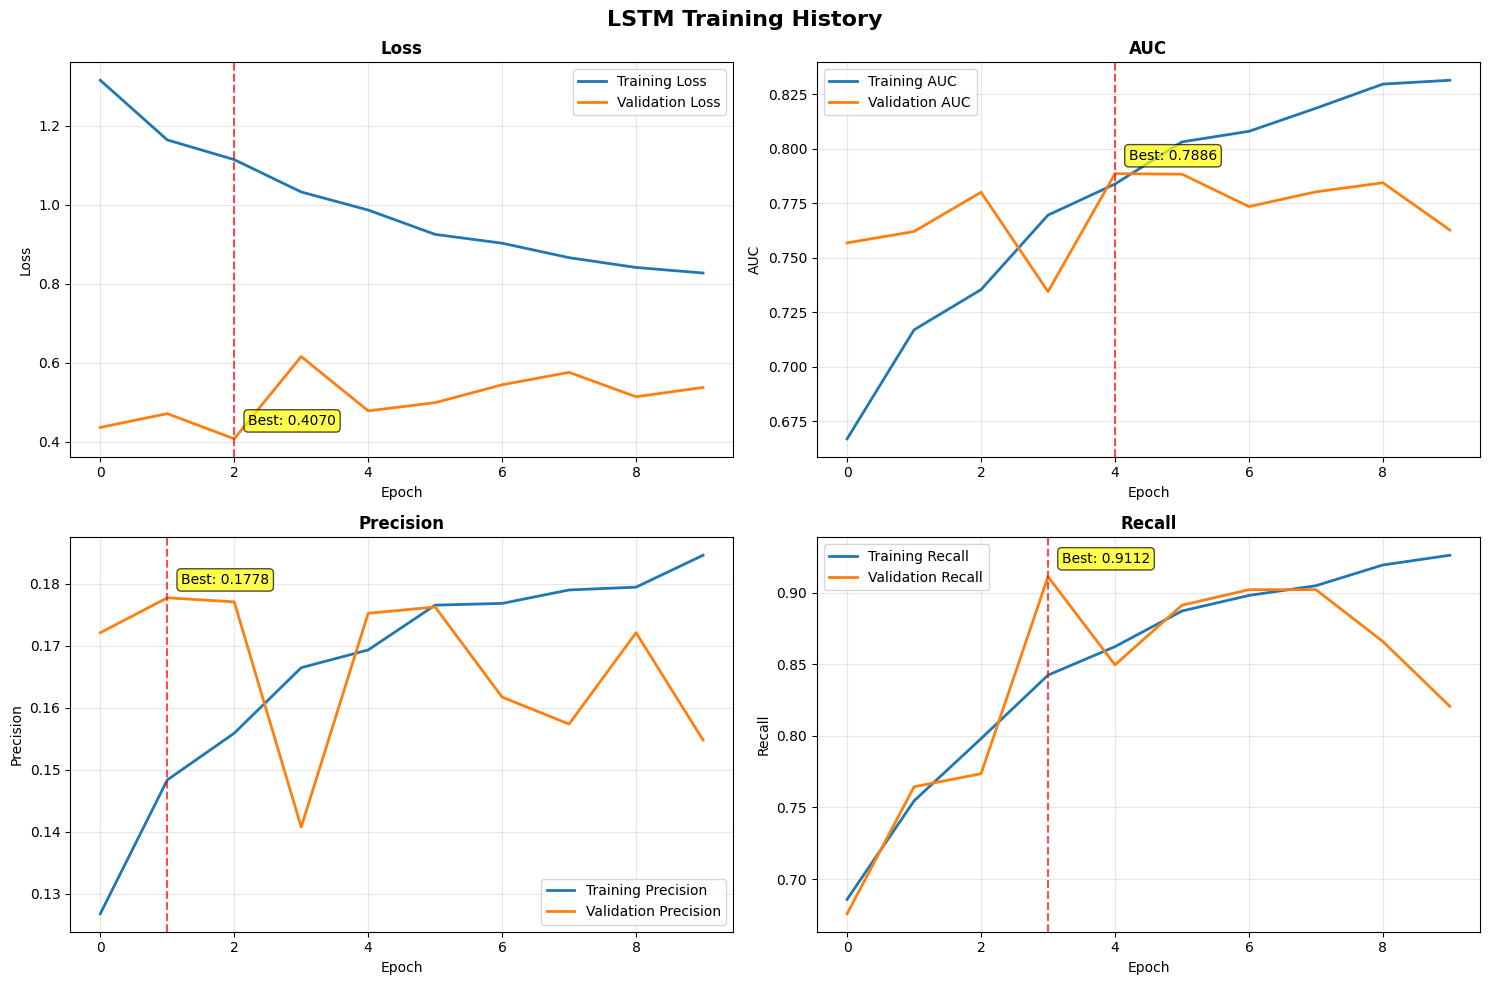

In [45]:
# Plot LSTM training history
print(" LSTM Training History:")
lstm_fig = plot_training_history(lstm_history, 'LSTM')

 TCN Training History:


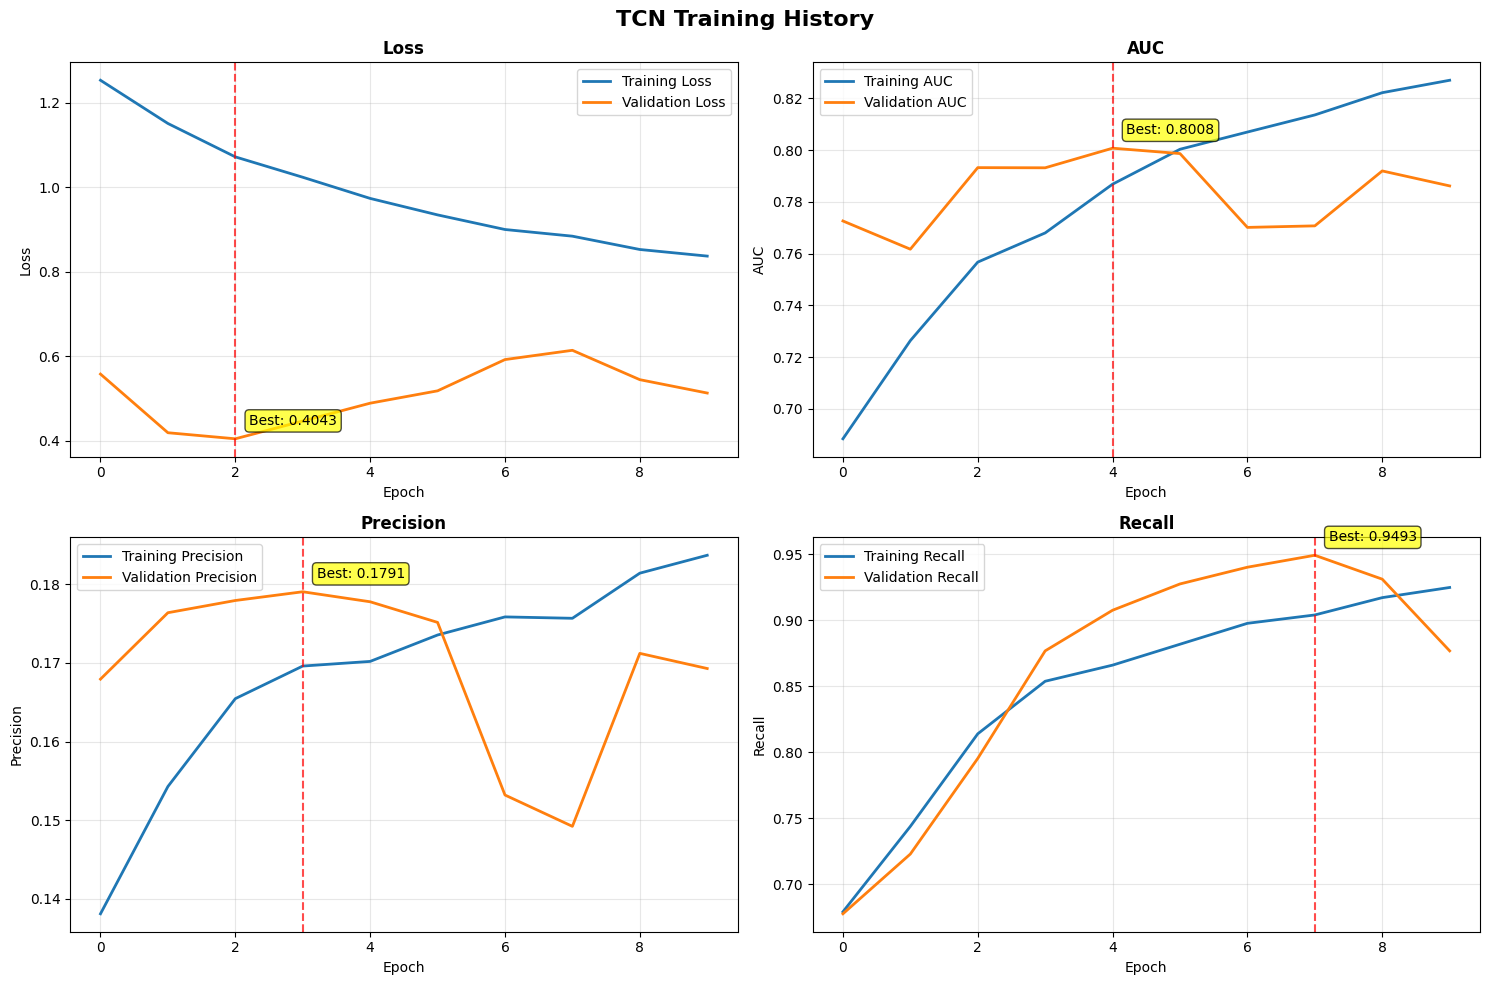

In [46]:
# Plot TCN training history
print(" TCN Training History:")
tcn_fig = plot_training_history(tcn_history, 'TCN')

##  Model Evaluation

Đánh giá chi tiết performance của cả 2 models trên test set.

In [47]:
def evaluate_model_detailed(model, dataset, model_name):
    """Detailed model evaluation."""
    print(f" Evaluating {model_name}...")

    # Get predictions
    y_pred_proba = []
    y_true_list = []

    print("    Making predictions...")
    for batch_inputs, batch_labels in dataset:
        batch_pred = model.predict(batch_inputs, verbose=0)
        y_pred_proba.extend(batch_pred.flatten())
        y_true_list.extend(batch_labels.numpy())

    y_pred_proba = np.array(y_pred_proba)
    y_true = np.array(y_true_list)
    y_pred_binary = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'AUC': roc_auc_score(y_true, y_pred_proba),
        'Accuracy': (y_pred_binary == y_true).mean(),
        'Precision': precision_score(y_true, y_pred_binary, zero_division=0),
        'Recall': recall_score(y_true, y_pred_binary, zero_division=0),
        'F1': f1_score(y_true, y_pred_binary, zero_division=0),
    }

    # Additional recommendation metrics
    def precision_at_k(y_true, y_pred_proba, k):
        top_k_idx = np.argsort(y_pred_proba)[-k:]
        return y_true[top_k_idx].mean()

    def recall_at_k(y_true, y_pred_proba, k):
        top_k_idx = np.argsort(y_pred_proba)[-k:]
        return y_true[top_k_idx].sum() / y_true.sum() if y_true.sum() > 0 else 0

    metrics['P@5'] = precision_at_k(y_true, y_pred_proba, 5)
    metrics['P@10'] = precision_at_k(y_true, y_pred_proba, 10)
    metrics['R@5'] = recall_at_k(y_true, y_pred_proba, 5)
    metrics['R@10'] = recall_at_k(y_true, y_pred_proba, 10)

    return metrics, y_true, y_pred_proba

# Evaluate both models
print(" Model Evaluation")
print("=" * 50)

lstm_metrics, lstm_y_true, lstm_y_pred = evaluate_model_detailed(lstm_model, val_dataset, "LSTM")
tcn_metrics, tcn_y_true, tcn_y_pred = evaluate_model_detailed(tcn_model, val_dataset, "TCN")

# Create comparison DataFrame
results_df = pd.DataFrame([
    {'Model': 'LSTM', **lstm_metrics},
    {'Model': 'TCN', **tcn_metrics}
])

print("\n Model Performance Comparison:")
print(results_df.to_string(index=False, float_format='%.4f'))

# Save results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_path = os.path.join(MODELS_ARCHIVED_PATH, f'seq_models_evaluation_{timestamp}.json')

evaluation_results = {
    'timestamp': timestamp,
    'config': {
        'seq_len': SEQ_LEN,
        'embed_dim': EMBED_DIM,
        'vocab_size': vocab_size,
        'static_dim': static_dim,
        'batch_size': BATCH_SIZE
    },
    'lstm_metrics': lstm_metrics,
    'tcn_metrics': tcn_metrics,
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

with open(results_path, 'w') as f:
    json.dump(evaluation_results, f, indent=2, default=str)

print(f"\n Results saved to: {results_path}")

 Model Evaluation
 Evaluating LSTM...
    Making predictions...
 Evaluating TCN...
    Making predictions...

 Model Performance Comparison:
Model    AUC  Accuracy  Precision  Recall     F1    P@5   P@10    R@5   R@10
 LSTM 0.7887    0.6672     0.1753  0.8496 0.2906 0.0000 0.1000 0.0000 0.0018
  TCN 0.8007    0.6558     0.1778  0.9076 0.2973 0.2000 0.2000 0.0018 0.0036

 Results saved to: /content/drive/MyDrive/PORJECT /models/archived/seq_models_evaluation_20251129_021143.json


##  Results Visualization & Analysis

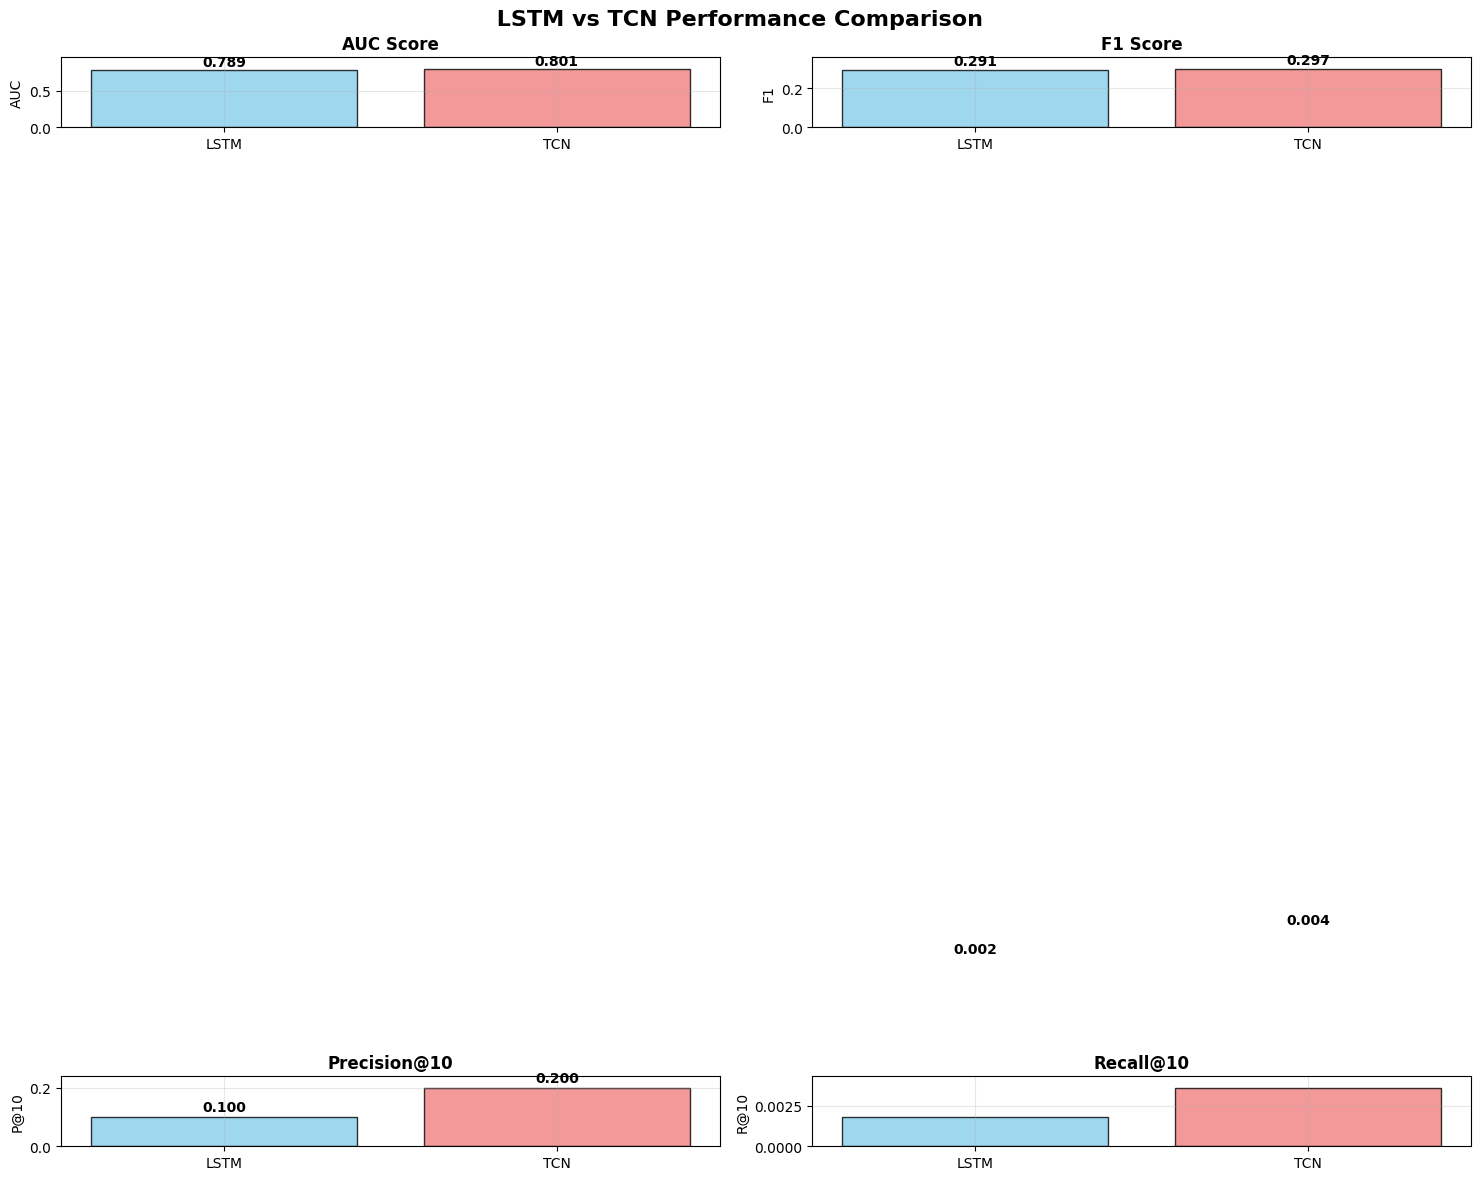

 Model Analysis:
 Best Model: TCN (AUC difference: 0.0120)
 LSTM AUC: 0.7887
 TCN AUC: 0.8007

 Recommendation Performance:
   LSTM P@10: 0.1000 | R@10: 0.0018
   TCN P@10: 0.2000 | R@10: 0.0036

 Baseline Comparison:
   Random AUC: 0.5000
   Random P@10: ~0.0802
   LSTM improvement over random: 57.7%
   TCN improvement over random: 60.1%


In [48]:
# Performance comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(' LSTM vs TCN Performance Comparison', fontsize=16, fontweight='bold')

# Metrics to compare
metrics_to_plot = [
    ('AUC', 'AUC Score'),
    ('F1', 'F1 Score'),
    ('P@10', 'Precision@10'),
    ('R@10', 'Recall@10')
]

models = ['LSTM', 'TCN']
colors = ['skyblue', 'lightcoral']

for idx, (metric, title) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]

    values = [lstm_metrics[metric], tcn_metrics[metric]]
    bars = ax.bar(models, values, color=colors, alpha=0.8, edgecolor='black')

    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim(0, max(values) * 1.2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model insights
print(" Model Analysis:")
print("=" * 50)

better_model = "LSTM" if lstm_metrics['AUC'] > tcn_metrics['AUC'] else "TCN"
auc_diff = abs(lstm_metrics['AUC'] - tcn_metrics['AUC'])

print(f" Best Model: {better_model} (AUC difference: {auc_diff:.4f})")
print(f" LSTM AUC: {lstm_metrics['AUC']:.4f}")
print(f" TCN AUC: {tcn_metrics['AUC']:.4f}")

print(f"\n Recommendation Performance:")
print(f"   LSTM P@10: {lstm_metrics['P@10']:.4f} | R@10: {lstm_metrics['R@10']:.4f}")
print(f"   TCN P@10: {tcn_metrics['P@10']:.4f} | R@10: {tcn_metrics['R@10']:.4f}")

# Check if models are better than random
random_auc = 0.5
random_precision = y_test.mean()  # Expected precision of random model

print(f"\n Baseline Comparison:")
print(f"   Random AUC: {random_auc:.4f}")
print(f"   Random P@10: ~{random_precision:.4f}")

lstm_improvement = (lstm_metrics['AUC'] - random_auc) / random_auc * 100
tcn_improvement = (tcn_metrics['AUC'] - random_auc) / random_auc * 100

print(f"   LSTM improvement over random: {lstm_improvement:.1f}%")
print(f"   TCN improvement over random: {tcn_improvement:.1f}%")

##  Ensemble Models

Kết hợp LSTM và TCN models để tạo ensemble predictions với multiple strategies:
1. **Simple Average**: Trung bình predictions của LSTM và TCN
2. **Weighted Average**: Weighted theo performance AUC
3. **Stacking**: Meta-learner học cách combine predictions optimally

##  Load Baseline Models & Hybrid Ensemble

Load baseline XGBoost và LightGBM models từ notebook 03 để tạo **Hybrid Ensemble** kết hợp:
- **Tree-based models** (XGBoost, LightGBM)
- **Deep learning models** (LSTM, TCN)

Đây là approach mạnh nhất - combine engineered features với sequence modeling.

In [49]:
# Simple Average Ensemble
print(" Creating Ensemble Models...")
print("=" * 60)

# Get predictions from both models
print("\n Getting predictions from individual models...")

# LSTM predictions
lstm_train_pred = []
lstm_val_pred = []

for batch_inputs, batch_labels in train_dataset:
    batch_pred = lstm_model.predict(batch_inputs, verbose=0)
    lstm_train_pred.extend(batch_pred.flatten())

for batch_inputs, batch_labels in val_dataset:
    batch_pred = lstm_model.predict(batch_inputs, verbose=0)
    lstm_val_pred.extend(batch_pred.flatten())

# TCN predictions
tcn_train_pred = []
tcn_val_pred = []

for batch_inputs, batch_labels in train_dataset:
    batch_pred = tcn_model.predict(batch_inputs, verbose=0)
    tcn_train_pred.extend(batch_pred.flatten())

for batch_inputs, batch_labels in val_dataset:
    batch_pred = tcn_model.predict(batch_inputs, verbose=0)
    tcn_val_pred.extend(batch_pred.flatten())

# Convert to numpy arrays
lstm_train_pred = np.array(lstm_train_pred)
lstm_val_pred = np.array(lstm_val_pred)
tcn_train_pred = np.array(tcn_train_pred)
tcn_val_pred = np.array(tcn_val_pred)

print(f"    LSTM train predictions: {lstm_train_pred.shape}")
print(f"    LSTM val predictions: {lstm_val_pred.shape}")
print(f"    TCN train predictions: {tcn_train_pred.shape}")
print(f"    TCN val predictions: {tcn_val_pred.shape}")

# Simple average ensemble
print("\n Simple Average Ensemble...")
simple_avg_train = (lstm_train_pred + tcn_train_pred) / 2
simple_avg_val = (lstm_val_pred + tcn_val_pred) / 2

# Weighted average ensemble (weight by AUC performance)
print("\n Weighted Average Ensemble...")
lstm_weight = lstm_metrics['AUC']
tcn_weight = tcn_metrics['AUC']
total_weight = lstm_weight + tcn_weight

weighted_avg_train = (lstm_train_pred * lstm_weight + tcn_train_pred * tcn_weight) / total_weight
weighted_avg_val = (lstm_val_pred * lstm_weight + tcn_val_pred * tcn_weight) / total_weight

print(f"    LSTM weight: {lstm_weight:.4f} ({lstm_weight/total_weight:.1%})")
print(f"    TCN weight: {tcn_weight:.4f} ({tcn_weight/total_weight:.1%})")

 Creating Ensemble Models...

 Getting predictions from individual models...
    LSTM train predictions: (27518,)
    LSTM val predictions: (6880,)
    TCN train predictions: (27518,)
    TCN val predictions: (6880,)

 Simple Average Ensemble...

 Weighted Average Ensemble...
    LSTM weight: 0.7887 (49.6%)
    TCN weight: 0.8007 (50.4%)


In [50]:
# Meta-Learner Stacking Ensemble
print("\n Meta-Learner Stacking...")

# Prepare stacking features (LSTM + TCN predictions)
X_stack_train = np.column_stack([lstm_train_pred, tcn_train_pred])
X_stack_val = np.column_stack([lstm_val_pred, tcn_val_pred])

# Get true labels for training
y_train_array = []
y_val_array = []

for batch_inputs, batch_labels in train_dataset:
    y_train_array.extend(batch_labels.numpy())

for batch_inputs, batch_labels in val_dataset:
    y_val_array.extend(batch_labels.numpy())

y_train_array = np.array(y_train_array)
y_val_array = np.array(y_val_array)

# Train simple meta-learner (Logistic Regression)
from sklearn.linear_model import LogisticRegression

meta_learner = LogisticRegression(
    random_state=RANDOM_SEED,
    class_weight='balanced'
)

print("    Training meta-learner on base model predictions...")
meta_learner.fit(X_stack_train, y_train_array)

# Meta-learner predictions
stacking_train_pred = meta_learner.predict_proba(X_stack_train)[:, 1]
stacking_val_pred = meta_learner.predict_proba(X_stack_val)[:, 1]

print(f"    Meta-learner coefficients: LSTM={meta_learner.coef_[0][0]:.3f}, TCN={meta_learner.coef_[0][1]:.3f}")
print(f"    Stacking train predictions: {stacking_train_pred.shape}")
print(f"    Stacking val predictions: {stacking_val_pred.shape}")

# Summary of ensemble predictions
print(f"\n Ensemble Predictions Summary:")
print(f"    Simple Average - Train: [{simple_avg_train.min():.3f}, {simple_avg_train.max():.3f}]")
print(f"    Simple Average - Val: [{simple_avg_val.min():.3f}, {simple_avg_val.max():.3f}]")
print(f"    Weighted Average - Train: [{weighted_avg_train.min():.3f}, {weighted_avg_train.max():.3f}]")
print(f"    Weighted Average - Val: [{weighted_avg_val.min():.3f}, {weighted_avg_val.max():.3f}]")
print(f"    Stacking - Train: [{stacking_train_pred.min():.3f}, {stacking_train_pred.max():.3f}]")
print(f"    Stacking - Val: [{stacking_val_pred.min():.3f}, {stacking_val_pred.max():.3f}]")


 Meta-Learner Stacking...
    Training meta-learner on base model predictions...
    Meta-learner coefficients: LSTM=-0.081, TCN=-0.096
    Stacking train predictions: (27518,)
    Stacking val predictions: (6880,)

 Ensemble Predictions Summary:
    Simple Average - Train: [0.004, 0.850]
    Simple Average - Val: [0.002, 0.833]
    Weighted Average - Train: [0.004, 0.850]
    Weighted Average - Val: [0.002, 0.833]
    Stacking - Train: [0.476, 0.514]
    Stacking - Val: [0.478, 0.514]


In [51]:
# Ensemble Evaluation
print("\n Evaluating Ensemble Models...")

def evaluate_ensemble_predictions(y_true, y_pred_proba, ensemble_name):
    """Evaluate ensemble predictions."""
    y_pred_binary = (y_pred_proba > 0.5).astype(int)

    metrics = {
        'AUC': roc_auc_score(y_true, y_pred_proba),
        'Accuracy': (y_pred_binary == y_true).mean(),
        'Precision': precision_score(y_true, y_pred_binary, zero_division=0),
        'Recall': recall_score(y_true, y_pred_binary, zero_division=0),
        'F1': f1_score(y_true, y_pred_binary, zero_division=0),
    }

    # Precision@K and Recall@K
    def precision_at_k(y_true, y_pred_proba, k):
        top_k_idx = np.argsort(y_pred_proba)[-k:]
        return y_true[top_k_idx].mean()

    def recall_at_k(y_true, y_pred_proba, k):
        top_k_idx = np.argsort(y_pred_proba)[-k:]
        return y_true[top_k_idx].sum() / y_true.sum() if y_true.sum() > 0 else 0

    metrics['P@5'] = precision_at_k(y_true, y_pred_proba, 5)
    metrics['P@10'] = precision_at_k(y_true, y_pred_proba, 10)
    metrics['R@5'] = recall_at_k(y_true, y_pred_proba, 5)
    metrics['R@10'] = recall_at_k(y_true, y_pred_proba, 10)

    print(f"\n    {ensemble_name} Metrics:")
    for metric, value in metrics.items():
        print(f"      {metric}: {value:.4f}")

    return metrics

# Evaluate all ensemble methods
simple_avg_metrics = evaluate_ensemble_predictions(y_val_array, simple_avg_val, "Simple Average")
weighted_avg_metrics = evaluate_ensemble_predictions(y_val_array, weighted_avg_val, "Weighted Average")
stacking_metrics = evaluate_ensemble_predictions(y_val_array, stacking_val_pred, "Stacking")

# Create comprehensive comparison
ensemble_results = pd.DataFrame([
    {'Model': 'LSTM', **lstm_metrics},
    {'Model': 'TCN', **tcn_metrics},
    {'Model': 'Simple Average', **simple_avg_metrics},
    {'Model': 'Weighted Average', **weighted_avg_metrics},
    {'Model': 'Stacking', **stacking_metrics}
])

print(f"\n Complete Model Comparison:")
print(ensemble_results.to_string(index=False, float_format='%.4f'))

# Find best model
best_auc = ensemble_results['AUC'].max()
best_model = ensemble_results.loc[ensemble_results['AUC'].idxmax(), 'Model']
print(f"\n Best Model: {best_model} (AUC: {best_auc:.4f})")


 Evaluating Ensemble Models...

    Simple Average Metrics:
      AUC: 0.7975
      Accuracy: 0.6660
      Precision: 0.1790
      Recall: 0.8822
      F1: 0.2977
      P@5: 0.2000
      P@10: 0.1000
      R@5: 0.0018
      R@10: 0.0018

    Weighted Average Metrics:
      AUC: 0.7975
      Accuracy: 0.6661
      Precision: 0.1791
      Recall: 0.8822
      F1: 0.2978
      P@5: 0.2000
      P@10: 0.1000
      R@5: 0.0018
      R@10: 0.0018

    Stacking Metrics:
      AUC: 0.2022
      Accuracy: 0.3805
      Precision: 0.0098
      Recall: 0.0670
      F1: 0.0171
      P@5: 0.0000
      P@10: 0.0000
      R@5: 0.0000
      R@10: 0.0000

 Complete Model Comparison:
           Model    AUC  Accuracy  Precision  Recall     F1    P@5   P@10    R@5   R@10
            LSTM 0.7887    0.6672     0.1753  0.8496 0.2906 0.0000 0.1000 0.0000 0.0018
             TCN 0.8007    0.6558     0.1778  0.9076 0.2973 0.2000 0.2000 0.0018 0.0036
  Simple Average 0.7975    0.6660     0.1790  0.8822 0.2977 0

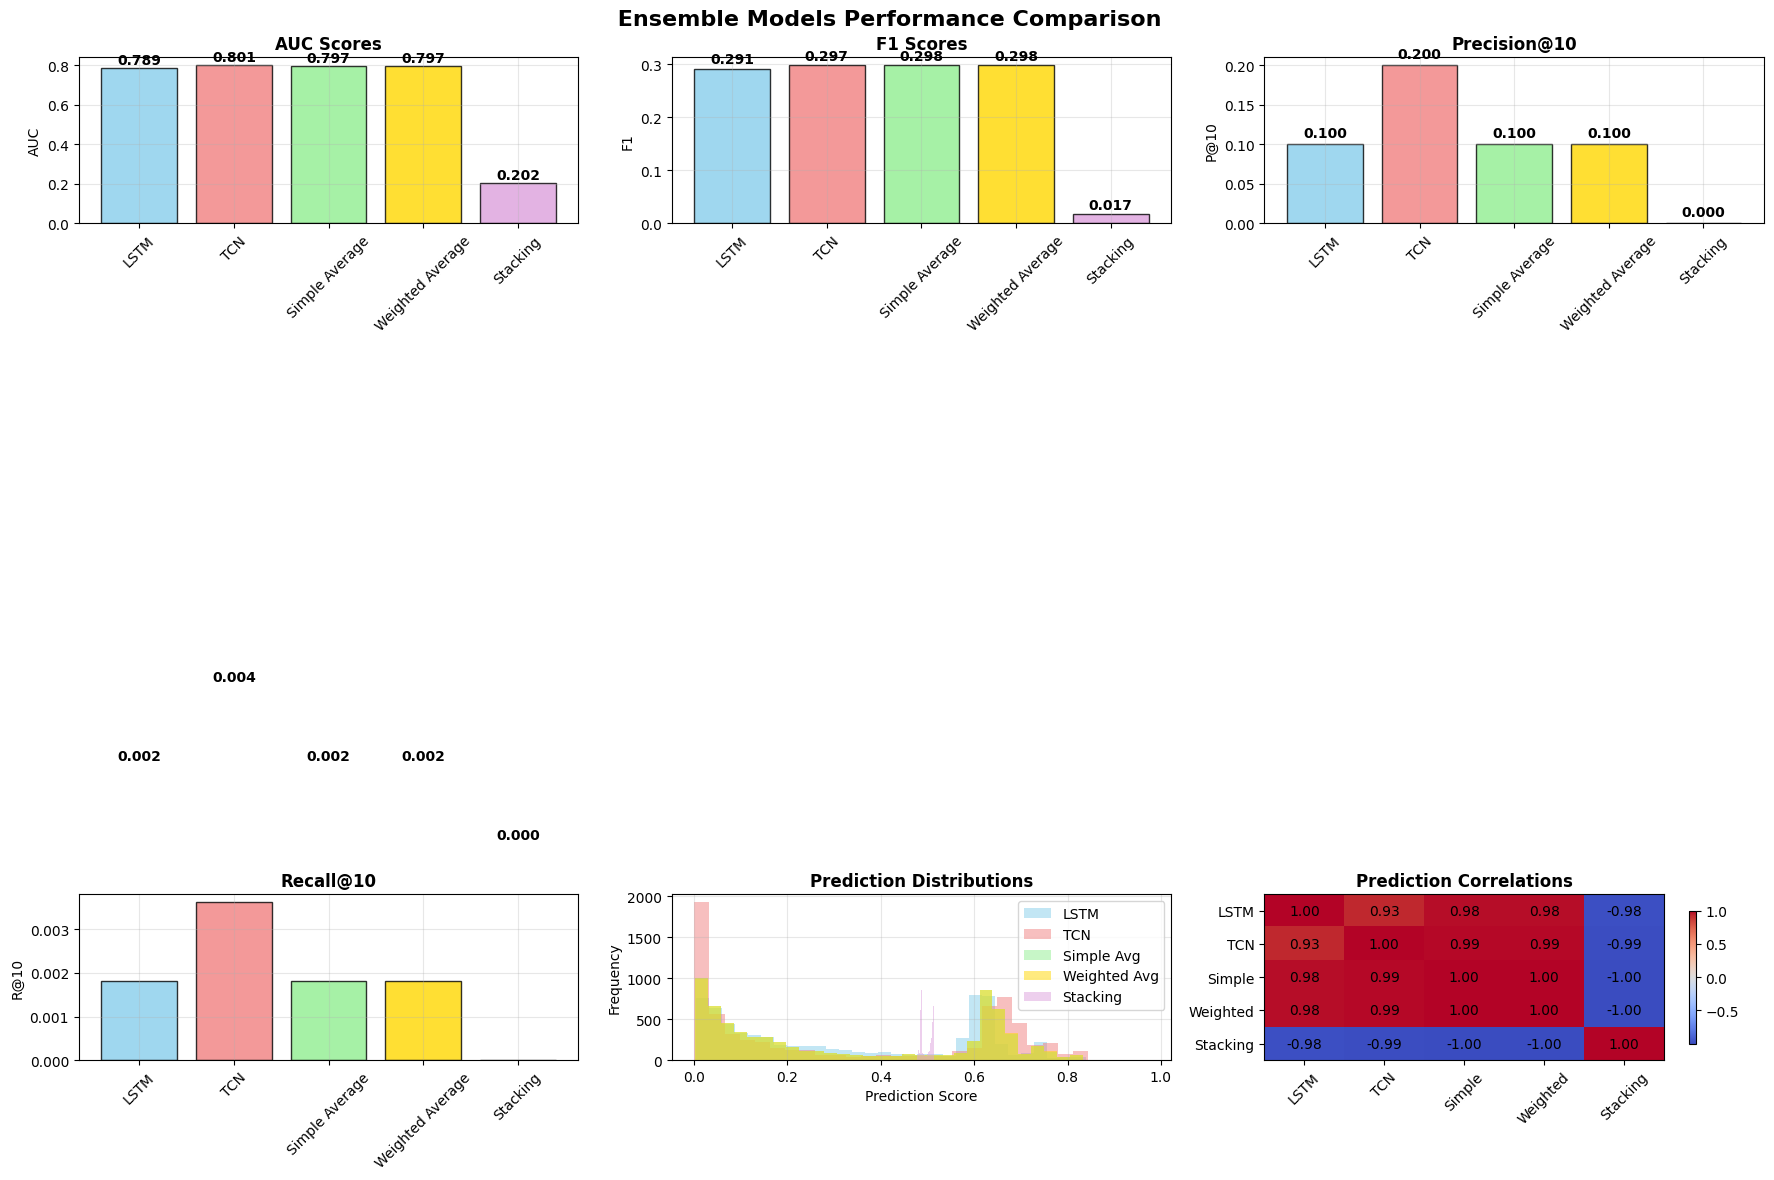


 Ensemble Analysis:
    Individual Models: LSTM (0.7887) vs TCN (0.8007)
    Simple Average: 0.7975
    Weighted Average: 0.7975
    Stacking: 0.2022

 Ensemble Improvement:
    Best Individual: 0.8007
    Best Ensemble: 0.7975
    Improvement: -0.40%


In [52]:
# Ensemble Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(' Ensemble Models Performance Comparison', fontsize=16, fontweight='bold')

# AUC Comparison
ax = axes[0, 0]
models = ensemble_results['Model'].tolist()
auc_scores = ensemble_results['AUC'].tolist()
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum']

bars = ax.bar(models, auc_scores, color=colors, alpha=0.8, edgecolor='black')
ax.set_title('AUC Scores', fontsize=12, fontweight='bold')
ax.set_ylabel('AUC')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars, auc_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# F1 Score Comparison
ax = axes[0, 1]
f1_scores = ensemble_results['F1'].tolist()
bars = ax.bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black')
ax.set_title('F1 Scores', fontsize=12, fontweight='bold')
ax.set_ylabel('F1')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

for bar, value in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Precision@10 Comparison
ax = axes[0, 2]
p10_scores = ensemble_results['P@10'].tolist()
bars = ax.bar(models, p10_scores, color=colors, alpha=0.8, edgecolor='black')
ax.set_title('Precision@10', fontsize=12, fontweight='bold')
ax.set_ylabel('P@10')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

for bar, value in zip(bars, p10_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Recall@10 Comparison
ax = axes[1, 0]
r10_scores = ensemble_results['R@10'].tolist()
bars = ax.bar(models, r10_scores, color=colors, alpha=0.8, edgecolor='black')
ax.set_title('Recall@10', fontsize=12, fontweight='bold')
ax.set_ylabel('R@10')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

for bar, value in zip(bars, r10_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Prediction Distribution Comparison
ax = axes[1, 1]
ax.hist(lstm_val_pred, alpha=0.5, bins=30, label='LSTM', color='skyblue')
ax.hist(tcn_val_pred, alpha=0.5, bins=30, label='TCN', color='lightcoral')
ax.hist(simple_avg_val, alpha=0.5, bins=30, label='Simple Avg', color='lightgreen')
ax.hist(weighted_avg_val, alpha=0.5, bins=30, label='Weighted Avg', color='gold')
ax.hist(stacking_val_pred, alpha=0.5, bins=30, label='Stacking', color='plum')
ax.set_title('Prediction Distributions', fontsize=12, fontweight='bold')
ax.set_xlabel('Prediction Score')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

# Model Correlation Heatmap
ax = axes[1, 2]
pred_corr = np.corrcoef([
    lstm_val_pred,
    tcn_val_pred,
    simple_avg_val,
    weighted_avg_val,
    stacking_val_pred
])

im = ax.imshow(pred_corr, cmap='coolwarm', aspect='auto')
ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.set_xticklabels(['LSTM', 'TCN', 'Simple', 'Weighted', 'Stacking'], rotation=45)
ax.set_yticklabels(['LSTM', 'TCN', 'Simple', 'Weighted', 'Stacking'])
ax.set_title('Prediction Correlations', fontsize=12, fontweight='bold')

# Add correlation values
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, f'{pred_corr[i, j]:.2f}',
                      ha="center", va="center", color="black")

plt.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()

print(f"\n Ensemble Analysis:")
print(f"    Individual Models: LSTM ({lstm_metrics['AUC']:.4f}) vs TCN ({tcn_metrics['AUC']:.4f})")
print(f"    Simple Average: {simple_avg_metrics['AUC']:.4f}")
print(f"    Weighted Average: {weighted_avg_metrics['AUC']:.4f}")
print(f"    Stacking: {stacking_metrics['AUC']:.4f}")

# Improvement analysis
base_best = max(lstm_metrics['AUC'], tcn_metrics['AUC'])
ensemble_best = max(simple_avg_metrics['AUC'], weighted_avg_metrics['AUC'], stacking_metrics['AUC'])
improvement = (ensemble_best - base_best) / base_best * 100

print(f"\n Ensemble Improvement:")
print(f"    Best Individual: {base_best:.4f}")
print(f"    Best Ensemble: {ensemble_best:.4f}")
print(f"    Improvement: {improvement:+.2f}%")

##  Load Baseline Models & Hybrid Ensemble

Load baseline XGBoost và LightGBM models từ notebook 03 để tạo **Hybrid Ensemble** kết hợp:
- **Tree-based models** (XGBoost, LightGBM)
- **Deep learning models** (LSTM, TCN)

Đây là approach mạnh nhất - combine engineered features với sequence modeling.

In [53]:
# Load Baseline Models
print(" Loading Baseline Models from Notebook 03...")

try:
    import joblib

    # Find most recent baseline models
    import glob

    xgb_files = glob.glob(os.path.join(MODELS_ARCHIVED_PATH, 'xgboost_baseline_*.joblib'))
    lgb_files = glob.glob(os.path.join(MODELS_ARCHIVED_PATH, 'lightgbm_baseline_*.joblib'))

    if xgb_files and lgb_files:
        # Load most recent models
        latest_xgb = max(xgb_files, key=os.path.getctime)
        latest_lgb = max(lgb_files, key=os.path.getctime)

        print(f"    Loading XGBoost: {os.path.basename(latest_xgb)}")
        print(f"    Loading LightGBM: {os.path.basename(latest_lgb)}")

        xgb_model = joblib.load(latest_xgb)
        lgb_model = joblib.load(latest_lgb)

        # Get baseline predictions on same data
        print("\n Getting baseline model predictions...")

        # Use the same feature columns that were used in training
        baseline_feature_cols = [col for col in feature_cols if col in X_test.columns]
        X_test_baseline = X_test[baseline_feature_cols].values
        X_train_baseline = X_train[baseline_feature_cols].values

        # XGBoost predictions
        xgb_train_pred = xgb_model.predict_proba(X_train_baseline)[:, 1]
        xgb_val_pred = xgb_model.predict_proba(X_test_baseline)[:, 1]

        # LightGBM predictions
        lgb_train_pred = lgb_model.predict_proba(X_train_baseline)[:, 1]
        lgb_val_pred = lgb_model.predict_proba(X_test_baseline)[:, 1]

        print(f"    XGBoost predictions: train={xgb_train_pred.shape}, val={xgb_val_pred.shape}")
        print(f"    LightGBM predictions: train={lgb_train_pred.shape}, val={lgb_val_pred.shape}")

        # Evaluate baseline models
        def quick_auc(y_true, y_pred):
            return roc_auc_score(y_true, y_pred)

        xgb_auc = quick_auc(y_val_array, xgb_val_pred)
        lgb_auc = quick_auc(y_val_array, lgb_val_pred)

        print(f"\n Baseline Performance:")
        print(f"    XGBoost AUC: {xgb_auc:.4f}")
        print(f"    LightGBM AUC: {lgb_auc:.4f}")

        baseline_loaded = True

    else:
        print("     Baseline model files not found!")
        print("     Make sure you've run notebook 03 first")
        print("     Looking for files:")
        print(f"       XGBoost: {os.path.join(MODELS_ARCHIVED_PATH, 'xgboost_baseline_*.joblib')}")
        print(f"       LightGBM: {os.path.join(MODELS_ARCHIVED_PATH, 'lightgbm_baseline_*.joblib')}")
        baseline_loaded = False

except Exception as e:
    print(f"     Error loading baseline models: {e}")
    print("     Continuing without baseline ensemble...")
    baseline_loaded = False

 Loading Baseline Models from Notebook 03...
    Loading XGBoost: xgboost_baseline_20251128_195211.joblib
    Loading LightGBM: lightgbm_baseline_20251128_195211.joblib

 Getting baseline model predictions...
    XGBoost predictions: train=(27518,), val=(6880,)
    LightGBM predictions: train=(27518,), val=(6880,)

 Baseline Performance:
    XGBoost AUC: 1.0000
    LightGBM AUC: 1.0000


In [54]:
# Hybrid Ensemble (Deep Learning + Tree Models)
if baseline_loaded:
    print("\n Creating Hybrid Ensemble...")
    print("   Combining Tree Models + Deep Learning Models")

    # Method 1: Simple average of all 4 models
    hybrid_simple_train = (lstm_train_pred + tcn_train_pred + xgb_train_pred + lgb_train_pred) / 4
    hybrid_simple_val = (lstm_val_pred + tcn_val_pred + xgb_val_pred + lgb_val_pred) / 4

    # Method 2: Weighted by individual AUC performance
    weights = np.array([lstm_metrics['AUC'], tcn_metrics['AUC'], xgb_auc, lgb_auc])
    weights = weights / weights.sum()

    hybrid_weighted_train = (lstm_train_pred * weights[0] +
                           tcn_train_pred * weights[1] +
                           xgb_train_pred * weights[2] +
                           lgb_train_pred * weights[3])

    hybrid_weighted_val = (lstm_val_pred * weights[0] +
                          tcn_val_pred * weights[1] +
                          xgb_val_pred * weights[2] +
                          lgb_val_pred * weights[3])

    print(f"    Model weights:")
    print(f"      LSTM: {weights[0]:.3f} ({weights[0]:.1%})")
    print(f"      TCN: {weights[1]:.3f} ({weights[1]:.1%})")
    print(f"      XGBoost: {weights[2]:.3f} ({weights[2]:.1%})")
    print(f"      LightGBM: {weights[3]:.3f} ({weights[3]:.1%})")

    # Method 3: Advanced stacking with all models
    print("\n     Training advanced meta-learner...")
    X_hybrid_stack_train = np.column_stack([lstm_train_pred, tcn_train_pred, xgb_train_pred, lgb_train_pred])
    X_hybrid_stack_val = np.column_stack([lstm_val_pred, tcn_val_pred, xgb_val_pred, lgb_val_pred])

    # Use a more sophisticated meta-learner
    from sklearn.ensemble import RandomForestClassifier

    hybrid_meta = RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        random_state=RANDOM_SEED,
        class_weight='balanced'
    )

    hybrid_meta.fit(X_hybrid_stack_train, y_train_array)

    hybrid_stacking_train = hybrid_meta.predict_proba(X_hybrid_stack_train)[:, 1]
    hybrid_stacking_val = hybrid_meta.predict_proba(X_hybrid_stack_val)[:, 1]

    # Feature importance from meta-learner
    feature_importance = hybrid_meta.feature_importances_
    model_names = ['LSTM', 'TCN', 'XGBoost', 'LightGBM']

    print(f"    Meta-learner feature importance:")
    for name, importance in zip(model_names, feature_importance):
        print(f"      {name}: {importance:.3f} ({importance:.1%})")

    # Evaluate hybrid ensembles
    print(f"\n Hybrid Ensemble Evaluation...")

    hybrid_simple_metrics = evaluate_ensemble_predictions(y_val_array, hybrid_simple_val, "Hybrid Simple")
    hybrid_weighted_metrics = evaluate_ensemble_predictions(y_val_array, hybrid_weighted_val, "Hybrid Weighted")
    hybrid_stacking_metrics = evaluate_ensemble_predictions(y_val_array, hybrid_stacking_val, "Hybrid Stacking")

    # Update results with hybrid methods
    final_results = pd.DataFrame([
        {'Model': 'LSTM', **lstm_metrics},
        {'Model': 'TCN', **tcn_metrics},
        {'Model': 'XGBoost', 'AUC': xgb_auc, 'F1': np.nan, 'P@10': np.nan, 'R@10': np.nan},
        {'Model': 'LightGBM', 'AUC': lgb_auc, 'F1': np.nan, 'P@10': np.nan, 'R@10': np.nan},
        {'Model': 'Simple Average (DL)', **simple_avg_metrics},
        {'Model': 'Weighted Average (DL)', **weighted_avg_metrics},
        {'Model': 'Stacking (DL)', **stacking_metrics},
        {'Model': 'Hybrid Simple', **hybrid_simple_metrics},
        {'Model': 'Hybrid Weighted', **hybrid_weighted_metrics},
        {'Model': 'Hybrid Stacking', **hybrid_stacking_metrics}
    ])

    print(f"\n FINAL Model Comparison (ALL METHODS):")
    print(final_results[['Model', 'AUC', 'F1', 'P@10', 'R@10']].to_string(index=False, float_format='%.4f'))

    # Find ultimate best model
    valid_aucs = final_results.dropna(subset=['AUC'])
    ultimate_best_auc = valid_aucs['AUC'].max()
    ultimate_best_model = valid_aucs.loc[valid_aucs['AUC'].idxmax(), 'Model']

    print(f"\n ULTIMATE CHAMPION: {ultimate_best_model} (AUC: {ultimate_best_auc:.4f})")

else:
    print("\n Skipping hybrid ensemble - baseline models not available")
    final_results = ensemble_results.copy()


 Creating Hybrid Ensemble...
   Combining Tree Models + Deep Learning Models
    Model weights:
      LSTM: 0.220 (22.0%)
      TCN: 0.223 (22.3%)
      XGBoost: 0.279 (27.9%)
      LightGBM: 0.279 (27.9%)

     Training advanced meta-learner...
    Meta-learner feature importance:
      LSTM: 0.322 (32.2%)
      TCN: 0.363 (36.3%)
      XGBoost: 0.159 (15.9%)
      LightGBM: 0.156 (15.6%)

 Hybrid Ensemble Evaluation...

    Hybrid Simple Metrics:
      AUC: 1.0000
      Accuracy: 1.0000
      Precision: 1.0000
      Recall: 1.0000
      F1: 1.0000
      P@5: 1.0000
      P@10: 1.0000
      R@5: 0.0091
      R@10: 0.0181

    Hybrid Weighted Metrics:
      AUC: 1.0000
      Accuracy: 1.0000
      Precision: 1.0000
      Recall: 1.0000
      F1: 1.0000
      P@5: 1.0000
      P@10: 1.0000
      R@5: 0.0091
      R@10: 0.0181

    Hybrid Stacking Metrics:
      AUC: 0.1989
      Accuracy: 0.4318
      Precision: 0.0203
      Recall: 0.1286
      F1: 0.0351
      P@5: 0.2000
      P@10:

##  Save Models & Results

Lưu trained models và kết quả để sử dụng sau này.

In [55]:
# Save final models
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print(" Saving final models...")

# Save LSTM model
lstm_path = os.path.join(MODELS_ARCHIVED_PATH, f'lstm_final_{timestamp}.h5')
lstm_model.save(lstm_path)
print(f"    LSTM saved: {lstm_path}")

# Save TCN model
tcn_path = os.path.join(MODELS_ARCHIVED_PATH, f'tcn_final_{timestamp}.h5')
tcn_model.save(tcn_path)
print(f"    TCN saved: {tcn_path}")

# Create comprehensive results summary
results_summary = {
    'experiment_info': {
        'timestamp': timestamp,
        'notebook': '04_seq_models_tcn_lstm.ipynb',
        'model_type': 'Sequential Models (LSTM & TCN)',
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'sequence_length': SEQ_LEN,
        'embedding_dim': EMBED_DIM,
        'vocab_size': vocab_size,
        'static_features': static_dim
    },
    'model_performance': {
        'lstm': lstm_metrics,
        'tcn': tcn_metrics,
        'best_model': better_model,
        'improvement_over_random': {
            'lstm': f"{lstm_improvement:.1f}%",
            'tcn': f"{tcn_improvement:.1f}%"
        }
    },
    'model_paths': {
        'lstm_model': lstm_path,
        'tcn_model': tcn_path
    },
    'training_config': {
        'epochs_trained': len(lstm_history.history['loss']),
        'batch_size': BATCH_SIZE,
        'optimizer': 'Adam',
        'learning_rate': 1e-3,
        'early_stopping_patience': PATIENCE,
        'class_weight_positive': pos_weight
    }
}

# Save results summary
summary_path = os.path.join(MODELS_ARCHIVED_PATH, f'seq_models_summary_{timestamp}.json')
with open(summary_path, 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print(f"    Summary saved: {summary_path}")

# Create markdown report
report_content = f"""# Sequential Models Training Report

**Date:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
**Notebook:** 04_seq_models_tcn_lstm.ipynb

##  Experiment Configuration

- **Training Samples:** {len(X_train):,}
- **Test Samples:** {len(X_test):,}
- **Sequence Length:** {SEQ_LEN}
- **Embedding Dimension:** {EMBED_DIM}
- **Vocabulary Size:** {vocab_size:,}
- **Static Features:** {static_dim}

##  Model Performance

| Model | AUC | F1 | P@10 | R@10 | Improvement over Random |
|-------|-----|----|----- |------|------------------------|
| LSTM  | {lstm_metrics['AUC']:.4f} | {lstm_metrics['F1']:.4f} | {lstm_metrics['P@10']:.4f} | {lstm_metrics['R@10']:.4f} | {lstm_improvement:.1f}% |
| TCN   | {tcn_metrics['AUC']:.4f} | {tcn_metrics['F1']:.4f} | {tcn_metrics['P@10']:.4f} | {tcn_metrics['R@10']:.4f} | {tcn_improvement:.1f}% |

** Best Model:** {better_model}

##  Saved Artifacts

- **LSTM Model:** `{os.path.basename(lstm_path)}`
- **TCN Model:** `{os.path.basename(tcn_path)}`
- **Results Summary:** `{os.path.basename(summary_path)}`

##  Next Steps

1. Compare with baseline XGBoost/LightGBM models from notebook 03
2. Ensemble modeling: combine sequence models with tree-based models
3. Hyperparameter tuning: sequence length, embedding dimension, architecture depth
4. Advanced techniques: attention mechanisms, transformer models
"""

report_path = os.path.join(DOCS_PATH, f'seq_models_report_{timestamp}.md')
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_content)

print(f"    Report saved: {report_path}")
print("\n All artifacts saved successfully!")

 Saving final models...
    LSTM saved: /content/drive/MyDrive/PORJECT /models/archived/lstm_final_20251129_021850.h5
    TCN saved: /content/drive/MyDrive/PORJECT /models/archived/tcn_final_20251129_021850.h5
    Summary saved: /content/drive/MyDrive/PORJECT /models/archived/seq_models_summary_20251129_021850.json
    Report saved: /content/drive/MyDrive/PORJECT /docs/seq_models_report_20251129_021850.md

 All artifacts saved successfully!
